<a href="https://colab.research.google.com/github/berilldindar/Pneumonia-Detection-/blob/main/PneumoniaDetectionGoogLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.layers import  Flatten,Dense,Activation
from keras.models import Sequential

import glob, os, random

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten,Dropout
from keras.preprocessing.image import ImageDataGenerator
np.random.seed(22)

In [ ]:
def load_normal(norm_path):
    norm_files = np.array(os.listdir(norm_path))
    norm_labels = np.array(['normal']*len(norm_files))
    
    norm_images = []
    for image in tqdm(norm_files):
        image = cv2.imread(norm_path + image)
        image = cv2.resize(image, dsize=(200,200))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        norm_images.append(image)
        
    norm_images = np.array(norm_images)
    
    return norm_images, norm_labels
def load_pneumonia(pneu_path):
    pneu_files = np.array(os.listdir(pneu_path))
    pneu_labels = np.array([pneu_file.split('_')[1] for pneu_file in pneu_files])
    
    pneu_images = []
    for image in tqdm(pneu_files):
        image = cv2.imread(pneu_path + image)
        image = cv2.resize(image, dsize=(200,200))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        pneu_images.append(image)
        
    pneu_images = np.array(pneu_images)
    
    return pneu_images, pneu_labels

In [ ]:
norm_images, norm_labels = load_normal('/content/drive/MyDrive/FinalOdevDerin/train/NORMAL/')
pneu_images, pneu_labels = load_pneumonia('/content/drive/MyDrive/FinalOdevDerin/train/PNEUMONIA/')

100%|██████████| 3883/3883 [00:51<00:00, 75.44it/s]


In [ ]:
X_train = np.append(norm_images, pneu_images, axis=0)
y_train = np.append(norm_labels, pneu_labels)

In [ ]:
np.unique(y_train,return_counts=True)

(array(['bacteria', 'normal', 'virus'], dtype='<U8'),
 array([2538, 1349, 1345]))

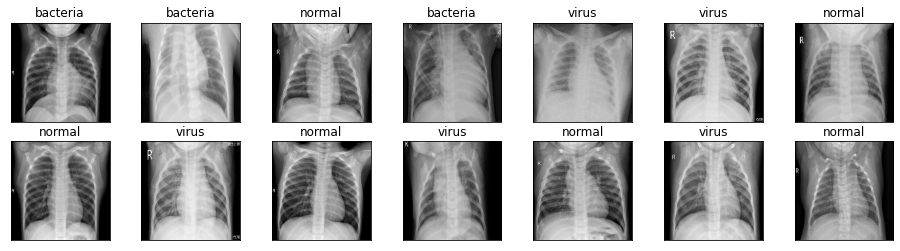

In [ ]:
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))

indices = np.random.choice(len(X_train), 14)
counter = 0

for i in range(2):
    for j in range(7):
        axes[i,j].set_title(y_train[indices[counter]])
        axes[i,j].imshow(X_train[indices[counter]], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        counter += 1
plt.show()

In [ ]:
norm_images_test, norm_labels_test = load_normal('/content/drive/MyDrive/FinalOdevDerin/test/NORMAL/')
pneu_images_test, pneu_labels_test = load_pneumonia('/content/drive/MyDrive/FinalOdevDerin/test/PNEUMONIA/')
X_test = np.append(norm_images_test, pneu_images_test, axis=0)
y_test = np.append(norm_labels_test, pneu_labels_test)

100%|██████████| 390/390 [00:04<00:00, 84.80it/s]


In [ ]:
with open('pneumonia_data.pickle', 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)
with open('pneumonia_data.pickle', 'rb') as f:
    (X_train, X_test, y_train, y_test) = pickle.load(f)

In [ ]:
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]

In [ ]:
one_hot_encoder = OneHotEncoder(sparse=False)

In [ ]:
y_train_one_hot = one_hot_encoder.fit_transform(y_train)
y_test_one_hot = one_hot_encoder.transform(y_test)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [ ]:
datagen = ImageDataGenerator(
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1,
        validation_split=0.1, 
        height_shift_range = 0.1)

In [ ]:
datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train_one_hot, batch_size = 32)

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
print(input_shape)

(200, 200, 1)


In [ ]:
from keras.models import Sequential,Model
from keras.layers.core import Flatten,Dense,Dropout
from keras.layers import Conv2D,MaxPooling2D,Input,Concatenate,AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
def inception(x,filtreler):
  #1x1
  path1=Conv2D(filters=filtreler[0],kernel_size=(1,1),strides=1,padding='same',activation='relu')(x)

  #1x1-> 3x3
  path2=Conv2D(filters=filtreler[1][0],kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(x)
  path2=Conv2D(filters=filtreler[1][1],kernel_size=(3,3),strides=(1,1),padding='same',activation='relu')(path2)

  #1x1->5x5
  path3=Conv2D(filters=filtreler[2][0],kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(x) 
  path3=Conv2D(filters=filtreler[2][1],kernel_size=(5,5),strides=(1,1),padding='same',activation='relu')(path3)

  #3x3->1x1
  path4=MaxPooling2D(pool_size=(3,3),strides=1,padding='same')(x)
  path4=Conv2D(filters=filtreler[3],kernel_size=(1,1),strides=(1,1),padding='same',activation='relu')(path4)

  return Concatenate(axis=-1)([path1,path2,path3,path4])

In [ ]:
input1 = Input(shape=(X_train.shape[1], X_train.shape[2], 1))
#stage 1
layer=Conv2D(64,kernel_size=(7,7),strides=(2,2),padding='same',activation='relu')(input1)
layer=MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(layer)

#stage 2
layer=Conv2D(64,kernel_size=(1,1),strides=1,padding='same',activation='relu')(layer)
layer=Conv2D(192,kernel_size=(3,3),strides=1,padding='same',activation='relu')(layer)
layer=MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(layer)

#stage3
layer=inception(layer,[64,(96,128),(16,32),32]) #3a
layer=inception(layer,[128,(128,192),(32,96),64]) #3b
layer=MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(layer)

#stage4
layer=inception(layer,[192,(96,208),(16,48),64]) #4a
layer=inception(layer,[160,(112,224),(24,64),64]) #4b
layer=inception(layer,[128,(128,256),(24,64),64]) #4c
layer=inception(layer,[112,(144,288),(32,64),64]) #4d
layer=inception(layer,[256,(160,320),(32,128),128]) #4e
layer=MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(layer)

#stage5
layer=inception(layer,[256,(160,320),(32,128),128]) #5a
layer=inception(layer,[384,(192,384),(48,128),128]) #5b
layer=AveragePooling2D(pool_size=(7,7),strides=1,padding='valid')(layer)

layer=Flatten()(layer)
layer=Dense(256,activation='linear')(layer)
main_out=Dense(3,activation='softmax',name='main')(layer)
model=Model(inputs=input1,outputs=[main_out])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 100, 64) 3200        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 50, 50, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 50, 64)   4160        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['acc'])

In [ ]:
history = model.fit(train_gen, epochs=10, 
          validation_data=(X_test, y_test_one_hot))


model.save('pneumonia_cnn.h5')

Epoch 1/10
164/164 [==============================] - 1032s 6s/step - loss: 2.0909 - acc: 0.4627 - val_loss: 1.0712 - val_acc: 0.4808
Epoch 2/10
164/164 [==============================] - 1002s 6s/step - loss: 0.8960 - acc: 0.5797 - val_loss: 1.1450 - val_acc: 0.4776
Epoch 3/10
164/164 [==============================] - 1000s 6s/step - loss: 0.8507 - acc: 0.6099 - val_loss: 0.8868 - val_acc: 0.6138
Epoch 4/10
164/164 [==============================] - 994s 6s/step - loss: 0.8228 - acc: 0.6239 - val_loss: 0.9847 - val_acc: 0.6571
Epoch 5/10
164/164 [==============================] - 990s 6s/step - loss: 0.8030 - acc: 0.6362 - val_loss: 0.9227 - val_acc: 0.6282
Epoch 6/10
164/164 [==============================] - 989s 6s/step - loss: 0.7784 - acc: 0.6620 - val_loss: 0.9101 - val_acc: 0.6603
Epoch 7/10
164/164 [==============================] - 989s 6s/step - loss: 0.7683 - acc: 0.6718 - val_loss: 0.9556 - val_acc: 0.6715
Epoch 8/10
164/164 [==============================] - 987s 6s/step

Displaying accuracy


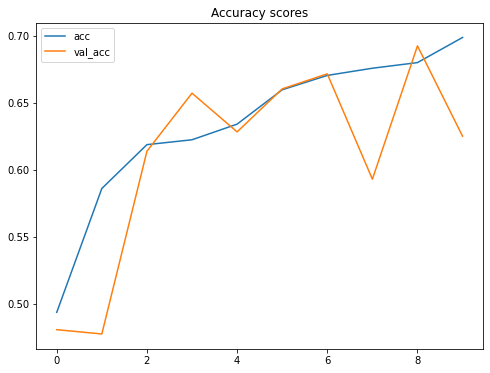

Displaying loss


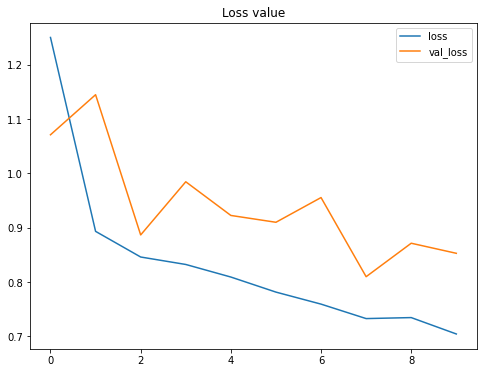

In [ ]:
print('Displaying accuracy')
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.show()

print('Displaying loss')
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
predictions = model.predict(X_test)
print(predictions)

[[0.852738   0.01532492 0.1319371 ]
 [0.5421312  0.20109357 0.25677526]
 [0.7904353  0.0214899  0.18807474]
 ...
 [0.4647831  0.01786186 0.517355  ]
 [0.43077767 0.01118226 0.5580401 ]
 [0.48832694 0.01160921 0.5000639 ]]


In [ ]:
predictions = one_hot_encoder.inverse_transform(predictions)

In [ ]:
print('Model evaluation')
print(one_hot_encoder.categories_)

classnames = ['bacteria', 'normal', 'virus']

Model evaluation
[array(['bacteria', 'normal', 'virus'], dtype='<U8')]


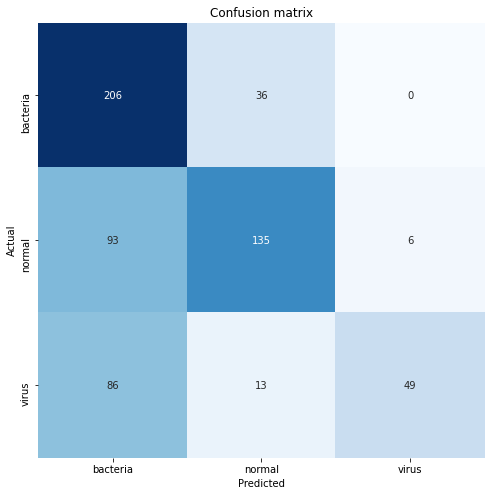

In [ ]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,8))
plt.title('Confusion matrix')
sns.heatmap(cm, cbar=False, xticklabels=classnames, yticklabels=classnames, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
print('Classification Report')
target_names = ['normal',  'bacteria',  'virus']
print(classification_report(y_test,predictions, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      normal       0.54      0.85      0.66       242
    bacteria       0.73      0.58      0.65       234
       virus       0.89      0.33      0.48       148

    accuracy                           0.62       624
   macro avg       0.72      0.59      0.60       624
weighted avg       0.69      0.62      0.61       624

